In [7]:
import pandas as pd
import numpy as np

In [36]:
data = pd.read_csv('atm_data_m2.csv')
data

Unnamed: 0        atm_name    weekday festival_religion working_day  \
0             11  Mount Road ATM     MONDAY                NH           W   
1             16  Mount Road ATM    TUESDAY                NH           W   
2             21  Mount Road ATM  WEDNESDAY                NH           W   
3             26  Mount Road ATM   THURSDAY                NH           W   
4             31  Mount Road ATM     FRIDAY                NH           W   
...          ...             ...        ...               ...         ...   
2239       11565  Mount Road ATM     MONDAY                NH           W   
2240       11570  Mount Road ATM    TUESDAY                NH           W   
2241       11575  Mount Road ATM  WEDNESDAY                NH           W   
2242       11580  Mount Road ATM   THURSDAY                NH           W   
2243       11585  Mount Road ATM     FRIDAY                 H           H   

     holiday_sequence  trans_date_set  trans_month  trans_year  prevweek_mean  \
0                 WWW               1            1        2011       648600.0   
1                 WWW               1            1        2011       648600.0   
2                 WWW               1            1        2011       648600.0   
3                 WWW               2            1        2011       648600.0   
4                 WWW               2            1        2011       648600.0   
...               ...             ...          ...         ...            ...   
2239              HWW               5            9        2017       276058.0   
2240              WWW               6            9        2017       276058.0   
2241              WWW               6            9        2017       276058.0   
2242              WWH               6            9        2017       276058.0   
2243              WHH               6            9        2017       276058.0   

      total_amount_withdrawn  
0                     897100  
1                     826000  
2                     754400  
3                     834200  
4                     575300  
...                      ...  
2239                  447400  
2240                  153800  
2241                  167100  
2242                  317400  
2243                  305100  

[2244 rows x 11 columns]

In [9]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

count       2244.0
mean      515717.0
std       255179.0
min          100.0
25%       349475.0
50%       514100.0
75%       684925.0
max      1410700.0
Name: total_amount_withdrawn, dtype: float64

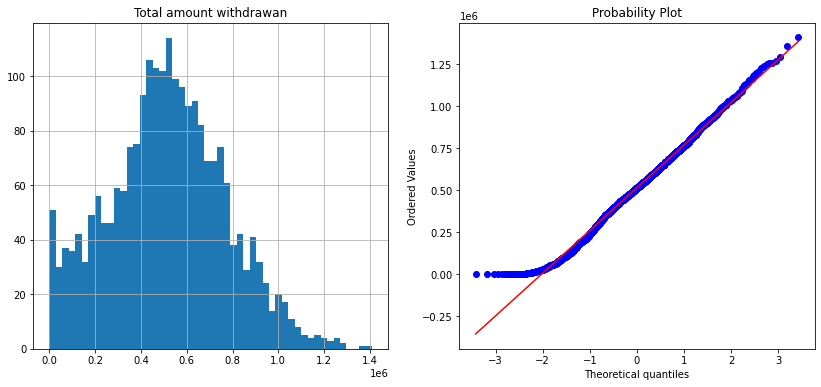

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['total_amount_withdrawn'].hist(bins=50)
plt.title('Total amount withdrawan')
plt.subplot(1,2,2)
stats.probplot(data['total_amount_withdrawn'], plot=plt);
data['total_amount_withdrawn'].describe().T.round()

In [11]:
# Copy the original data
features = data.copy()
# Select the numeric columns
numeric_subset = data[['trans_date_set','trans_month','trans_year','prevweek_mean', 'total_amount_withdrawn']]
# Select the categorical columns
# dropped atm_name
categorical_subset = data[['weekday','festival_religion', 'working_day',  'holiday_sequence']]
# One hot encoding
categorical_subset = pd.get_dummies(categorical_subset)
# Join the two dataframes using concat
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

In [12]:
from sklearn.model_selection import train_test_split
X = features.copy().drop(columns = ['total_amount_withdrawn', 'trans_date_set', 'trans_month','trans_year', 'working_day_H', 'working_day_W'])
y = features['total_amount_withdrawn'].copy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of Xtrain and Xtest: ', len(Xtrain), len(Xtest))
print('length of ytrain and ytest: ', len(ytrain), len(ytest))

length of Xtrain and Xtest:  1795 449
length of ytrain and ytest:  1795 449


In [13]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(Xtrain, ytrain)
# make predictions
lin_pred = linear.predict(Xtest)
# Prediction vs Actual
linpred = pd.DataFrame(lin_pred[-10:]) # predicting last 10 values
linpred.rename(columns = {0: 'lin_predicted'}, inplace=True) # renaming the column
linpred = linpred.round(decimals=0) # rounding the decimal values
d = pd.DataFrame(data['total_amount_withdrawn']).tail(10) # calling last 10 values of original amt wothdrawn
linpred.index = d.index # mapping the index of both dataframe
linok = pd.concat([linpred, d], axis=1)
linok['accuracy'] = round(linok.apply(lambda row: row.lin_predicted /row.total_amount_withdrawn *100, axis = 1),2)
linok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in linok['accuracy']],index = linok.index)
linok = linok.reset_index()
linok['index'] = pd.to_datetime(linok['index']) # convert to datetime type
linok['day_of_week'] = linok['index'].dt.day_name() # get the day of the week
linok = linok.drop(columns=['index']) # drop the original index column




In [14]:
linok

lin_predicted  total_amount_withdrawn accuracy day_of_week
0       508440.0                  308400  164.86%    Thursday
1       488103.0                  312600  156.14%    Thursday
2       461633.0                  337100  136.94%    Thursday
3       572903.0                  251100  228.16%    Thursday
4       374079.0                  182700  204.75%    Thursday
5       530596.0                  447400  118.60%    Thursday
6       506257.0                  153800  329.17%    Thursday
7       518418.0                  167100  310.24%    Thursday
8       524031.0                  317400  165.10%    Thursday
9       209299.0                  305100   68.60%    Thursday

In [15]:
mean_lin_test = ytest.mean()
mean_lin_pred = lin_pred.mean()
print(mean_lin_test, mean_lin_pred)

accuracy = (mean_lin_pred/mean_lin_test)*100

print("Excess prediction: %\n", format(round(accuracy,2)))

246600.89086859688 480655.8517569125
Excess prediction: %
 194.91


In [18]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective = 'reg:squarederror' )
xgb.fit(Xtrain, ytrain)

# make predictions

xgb_pred = xgb.predict(Xtest)

xgbpred = pd.DataFrame(xgb_pred[-10:])

xgbpred.rename(columns = {0: 'xgb_predicted'}, inplace=True)

xgbpred = xgbpred.round(decimals=0)

xgbpred.index = d.index

xgbok = pd.concat([xgbpred, d], axis=1)

import pandas as pd

# convert index to DatetimeIndex
xgbok.index = pd.to_datetime(xgbok.index)

# compute accuracy
xgbok['accuracy'] = round(xgbok.apply(lambda row: row.xgb_predicted/row.total_amount_withdrawn *100, axis=1),2)

# format accuracy as percentage
xgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in xgbok['accuracy']], index= xgbok.index)

# add day_of_week column
xgbok = xgbok.assign(day_of_week = lambda x: x.index.day_name())



In [19]:
xgbok

xgb_predicted  total_amount_withdrawn accuracy  \
1970-01-01 00:00:00.000002234        29213.0                  308400    9.47%   
1970-01-01 00:00:00.000002235       356450.0                  312600  114.03%   
1970-01-01 00:00:00.000002236       197966.0                  337100   58.73%   
1970-01-01 00:00:00.000002237        90477.0                  251100   36.03%   
1970-01-01 00:00:00.000002238       267407.0                  182700  146.36%   
1970-01-01 00:00:00.000002239       199052.0                  447400   44.49%   
1970-01-01 00:00:00.000002240       591902.0                  153800  384.85%   
1970-01-01 00:00:00.000002241       127836.0                  167100   76.50%   
1970-01-01 00:00:00.000002242       250156.0                  317400   78.81%   
1970-01-01 00:00:00.000002243        94842.0                  305100   31.09%   

                              day_of_week  
1970-01-01 00:00:00.000002234    Thursday  
1970-01-01 00:00:00.000002235    Thursday  
1970-01-01 00:00:00.000002236    Thursday  
1970-01-01 00:00:00.000002237    Thursday  
1970-01-01 00:00:00.000002238    Thursday  
1970-01-01 00:00:00.000002239    Thursday  
1970-01-01 00:00:00.000002240    Thursday  
1970-01-01 00:00:00.000002241    Thursday  
1970-01-01 00:00:00.000002242    Thursday  
1970-01-01 00:00:00.000002243    Thursday

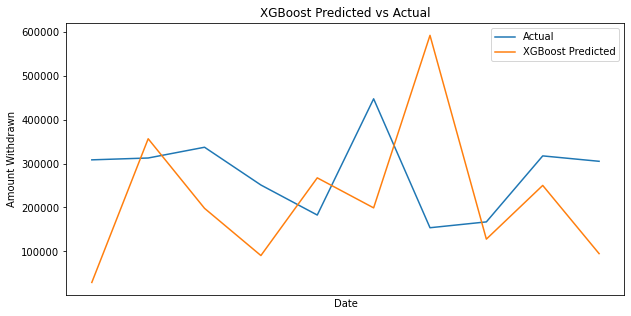

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(xgbok.index, xgbok.total_amount_withdrawn, label='Actual')
plt.plot(xgbok.index, xgbok.xgb_predicted, label='XGBoost Predicted')
plt.xlabel('Date')
plt.ylabel('Amount Withdrawn')
plt.title('XGBoost Predicted vs Actual')
plt.legend()
plt.show()


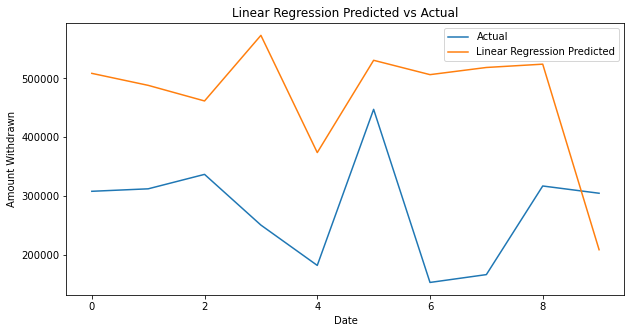

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(linok.index, linok.total_amount_withdrawn, label='Actual')
plt.plot(linok.index, linok.lin_predicted, label='Linear Regression Predicted')
plt.xlabel('Date')
plt.ylabel('Amount Withdrawn')
plt.title('Linear Regression Predicted vs Actual')
plt.legend()
plt.show()

In [25]:
mean_xgb_test = ytest.mean()
mean_xgb_pred = xgb_pred.mean()
print(mean_xgb_test, mean_xgb_pred)

accuracy = (mean_xgb_test / mean_xgb_pred)*100
print('accuracy:', round(accuracy, 2) )


246600.89086859688 286123.56
accuracy: 86.19


In [35]:
prediction_date = pd.Timestamp('2023-04-01')
prediction_features = pd.DataFrame({'day_of_week': [prediction_date.day_name()],
                                     'holiday': [0],
                                     'working_day': [1],
                                     'atm_name': [23],
                                     'atemp': [23],
                                     'humidity': [60],
                                     'windspeed': [15],
                                     'season_Spring': [0],
                                     'season_Summer': [1],
                                     'season_Winter': [0],
                                     'weather_Clear': [1],
                                     'weather_Cloudy': [0],
                                     'weather_Rain': [0]},
                                  'Unnamed: 0',
                                   'atm_name',
                                   'weekday',
                                   'festival_religion',
                                   'working_day',
                                   'holiday_sequence',
                                   'trans_date_set',
                                   'trans_month',
                                   'trans_year',
                                   'prevweek_mean',
                                   'total_amount_withdrawn')

# make prediction using XGBoost model
prediction = xgb.predict(prediction_features)

# print predicted value
print("Predicted value for {}: {}".format(prediction_date, prediction[0]))

ValueError: Feature shape mismatch, expected: 21, got 13